# Web Scraping: Part I
## Understanding Toronto's Real-Estate Market using Selenium
- First draft created: 2020-09-13
- Last modified: 2020-10-29

## 1. Background

2020 was no ordinary year for everyone. Due to the COVID-19 crisis, the global economy has greatly suffered resulting in business closures and job losses. However, the Canadian real estate sales have been flourishing primarily because Bank of Canada has announced to keep interest rate near zero until 2023, enabling Canadians to take advantage of low-interest rates for morgages.

## 2. Objectives
Since condominiums remain the most affordable option, I decided to focus on condo listings in Toronto. I used **House Sigma**, an online platform that uses artificial intelligence in estimating Canadian home value, as a source for data extraction. Since the website is highly interactive, **Selenium webdriver** was used for automating web scraping of hudreds of condo listings.

**Specific Aims** 
1. Extract property details of each condo listing to understand its market trends.
2. Identify and visualize relationships between variables

## 3. Using Selenium to automate web browser interactions
### 3.1 Import Libraries

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import Chrome
from time import sleep
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# # To check current version
# print(selenium.__version__)
# import selenium

# # Alternatively, install the latest version in the terminal
# pip install selenium==4.0.0a6

In [30]:
driver = Chrome() #webdriver downloaded and saved in the same folder
url ='https://housesigma.com'
driver.get(url)

#Clicking sign-in page
element = driver.find_element(By.XPATH, "//a[contains(@class, 'global-link user_left_part')]")
element.click()
sleep(1)

# Log-in
element_email = driver.find_element(By.XPATH, "//input[contains(@placeholder, 'Email Address')]")
element_email.send_keys('hykimusa@gmail.com')
element_pw = driver.find_element(By.XPATH, '//input[contains(@placeholder, "Password")]')
element_pw.send_keys('housesigmapw4$')
sleep(1)
element_sign_in_button = driver.find_element(By.XPATH, '//*[contains(@class, "el-button signin el-button--primary")]')
element_sign_in_button.click()

### 3.2 Setting filters
- In the Recommend tab
- Setting parameters to restrict my search to condos in Toronto

In [33]:
# Clicking the 'Recommend' button
element_recommend = driver.find_element(By.XPATH, '//*[text()="Recommend"]')
element_recommend.click()
sleep(2)

# Investment
element_investment_all = driver.find_element(By.XPATH,'//*[@id="recommend"]/div[3]/div[2]/div[2]/span[1]')
# element_investment_school = driver.find_element_by_xpath('//div[text()="School"]')
# element_investment_growth = driver.find_element_by_xpath('//div[text()="Growth"]')
# element_investment_rentalyield = driver.find_element_by_xpath('//div[text()="Rental Yeild"]')
# element_investment_land = driver.find_element_by_xpath('//div[text()="Land"]')
# sleep(1)

element_investment_all.click();
# element_investment_school.click()
# element_investment_growth.click()
# element_investment_rentalyield.click()
# element_investment_land.click()
# sleep(2)

# Property Type
# element_type_detached = driver.find_element_by_xpath('//div[text()="Detached"]')
# element_type_semidetached = driver.find_element_by_xpath('//div[text()="Semi-Detached"]')
# element_type_townhouse = driver.find_element_by_xpath('//div[text()="Townhouse"]')
element_type_condo = driver.find_element(By.XPATH, '//div[text()="Condo Apt"]')

# element_type_detached.click()
# element_type_semidetached.click()
# element_type_townhouse.click()
element_type_condo.click();
sleep(1)

# City/Location
# element_city_all = driver.find_element_by_xpath('//*[@id="recommend"]/div[3]/div[4]/div[2]/span[1]')
# element_city_reset = driver.find_element_by_xpath('//*[@id="recommend"]/div[3]/div[4]/div[2]/span[2]')
element_city_toronto = driver.find_element(By.XPATH, '/html/body/div/div/div[3]/div[4]/div[1]/div[1]/div[2]/span[1]')
# element_city_northyork = driver.find_element_by_xpath('//*[text()="North York"]')
# element_city_etobicoke = driver.find_element_by_xpath('//*[text()="Etobicoke"]')
# element_city_markham = driver.find_element_by_xpath('//*[text()="Markham"]')
# element_city_richmondhill = driver.find_element_by_xpath('//*[text()="Richmond Hill"]')
# element_city_scarborough = driver.find_element_by_xpath('//*[text()="Scarborough"]')
# element_city_all.click()

element_city_toronto.click();
# element_city_northyork.click()
# element_city_etobicoke.click()
# element_city_scarborough.click()
# element_city_markham.click()
# element_city_richmondhill.click()
sleep(1)

# Scroll to bottom
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

In [34]:
# Start Recommendation
element_start_recommendation = driver.find_element(By.XPATH, '//span[text()= "Start Recommendation"]')
element_start_recommendation.click()
# https://stackoverflow.com/questions/48665001/can-not-click-on-a-element-elementclickinterceptedexception-in-splinter-selen

# Open all pages
for i in range(10):
    driver.execute_script(f"window.scrollTo({i}, document.body.scrollHeight);")
    sleep(2) 

### 3.3 Creating Empty Lists
- 28 features in total

In [5]:
# Create empty lists

address=[]
city_name=[]
house_type=[]
bedroom=[] 
washroom=[] 
parking=[]
listing_price=[]

tax=[]
property_type=[]
basement=[]
utility_incl=[]
maintenance=[]
building_age=[]
size=[]
listing_num=[]
dom=[]
listed_on=[] 
updated_on=[]

sigma_estimate=[]
estimate_date=[]
rental_estimate=[]
rental_yield=[]
rental_dom=[]

intersection=[]
exposure=[]
amenities=[]
municipality=[]
description=[]

## 4. Scraping property details
- HouseSigma categorizes listings into neighbourhoods/communities
- You have to click each 'Community' to see the listings

In [35]:
# Finding total number of communities
community_list = driver.find_elements(By.XPATH, '//*[@id="recommend"]/div[3]/div[7]/div')
print("Total # of Communities: ", len(community_list))

Total # of Communities:  62


- The following loop will continue until all of the listings are scraped from all of the communities (unless you interrupt the kernel, of course)

In [38]:
for i in range(15, len(community_list)):
    try:
        element_community = driver.find_element(By.XPATH, f'//*[@id="recommend"]/div[3]/div[7]/div[{i}]/div[2]/div[2]/div[4]/span/button/span')
    except:
        element_community = driver.find_element(By.XPATH, f'//*[@id="recommend"]/div[3]/div[7]/div[{i}]/div[2]/div[2]/div[3]/span/button/span')
        
    #########################
    # Identify total number of listings in this community
    tot_num = element_community.text
    tot_num = int(tot_num.split(' ')[-1].replace('(',"").replace(')',""))
    
    # Determine how many times you need to scroll down in the pop-up window
    repeat_num = math.ceil(tot_num/15) # divide by 15 because there are 15 listings per view
    print('Total # of listing:', tot_num)
    print("Scrolling ", repeat_num, " times")
    sleep(3)
    
    # Clicks a community button to open up the pop-up page
    driver.execute_script("arguments[0].click();", element_community)
    print(f'Community-{i}')
    
    # Identify the pop-up window
    community_popup_window = driver.find_element(By.XPATH, '//div[@class="el-dialog el-dialog--center"]//a')
    
    # Scroll down until you finish repeat_num
    i = 1
    while i < repeat_num+1:
#         print(i)
        community_popup_window.send_keys(Keys.END)
        sleep(1)
        if i == repeat_num:
#             print("End of list")
            break
        i += 1
    sleep(3)
    #########################
    # Identifying each listing
    for i in range(1, tot_num+1):
        post = driver.find_element(By.XPATH, f'//*[@id="recommend"]/div[2]/div/div[2]/div[3]/div[1]/div[{i}]/div/div[1]/a')
        post.click() #clicks on the posted listing
        # new tab opens
        driver.switch_to.window(driver.window_handles[-1]) # moves controller to the last opened tab handle
        # now able to control the newly opened tab
        sleep(5)

        ###############################
        # Scraping listing details
        ###############################
        # MAIN
        ele_address = driver.find_element(By.CLASS_NAME, "address").text
        ele_city_name = driver.find_element(By.CLASS_NAME, "city_name").text
        ele_house_type = driver.find_element(By.CLASS_NAME, "house_type").text
        ele_bedroom = driver.find_element(By.XPATH, '//*[@id="room_count_to_estimate"]/div[1]/div/div/div[1]/span').text
        ele_washroom = driver.find_element(By.XPATH, '//*[@id="room_count_to_estimate"]/div[1]/div/div/div[2]/span').text
        ele_parking = driver.find_element(By.XPATH, '//*[@id="room_count_to_estimate"]/div[1]/div/div/div[3]/span').text
        try:
            ele_listing_price = driver.find_element(By.XPATH, '//div[contains(@class, "price_listing")]/span').text
        except:
            ele_listing_price = None
        ###############################
        # KEY FACTS
        key_facts = driver.find_element(By.XPATH, '//div[contains(@class, "two_column_data el-row")]').text.split('\n')
        
        try:
            ele_tax = key_facts[key_facts.index('Tax:')+1]
        except:
            ele_tax = None
        ele_property_type = key_facts[key_facts.index('Propery Type:')+1]
        try:
            ele_maintenance = key_facts[key_facts.index('Maintenance:')+1]      
        except:
            ele_maintenance = None
        try:
            ele_building_age = key_facts[key_facts.index('Building Age:')+1]
        except: 
            ele_building_age = None
        ele_size = key_facts[key_facts.index('Size:')+1]
        ele_listing_num = key_facts[key_facts.index('Listing #:')+1]
        ele_dom = key_facts[key_facts.index('Days on Market:')+1]
        ele_listed_on = key_facts[key_facts.index('Listed on:')+1]
        ele_updated_on = key_facts[key_facts.index('Updated On:')+1]
        try:
            ele_basement = key_facts[key_facts.index('Basement:')+1]
        except:
            ele_basement = None
        try:
            ele_utility_incl = key_facts[key_facts.index('Included Utility:')+1]
        except:
            ele_utility_incl = None
        
        ###############################
        # HOME VALUE
        home_value = driver.find_element(By.XPATH, '//div[contains(@class, "home_value")]').text.split('\n')
        
        ele_sigma_estimate = home_value[home_value.index('SigmaEstimate')+1]
        ele_estimate_date = home_value[home_value.index('Estimated Date')+1]
        ele_rental_estimate = home_value[home_value.index('Rental Estimate')+1]
        ele_rental_yield = home_value[home_value.index('Rental Yield')+1]
        ele_rental_dom = home_value[home_value.index('Rental Dom')+1]
        
        ###############################
        # PROPERTY DETAILS    
        prop_details = driver.find_element(By.XPATH, '//div[contains(@id, "property_details")]').text.split('\n')

        ele_intersection = prop_details[prop_details.index('Intersection:')+1]
        ele_exposure = prop_details[prop_details.index('Exposure:')+1]
        ele_municipality = prop_details[prop_details.index('Municipality:')+1]
        ele_description = prop_details[prop_details.index('Description')+1]
        try:
            ele_amenities = prop_details[prop_details.index('Amenities:')+1]
        except:
            ele_amenities = None
        
        ###############################
        # Append lists
        address.append(ele_address)
        city_name.append(ele_city_name)
        house_type.append(ele_house_type) 
        bedroom.append(ele_bedroom) 
        washroom.append(ele_washroom) 
        parking.append(ele_parking) 
        listing_price.append(ele_listing_price)   
        
        tax.append(ele_tax) 
        property_type.append(ele_property_type)
        basement.append(ele_basement)
        utility_incl.append(ele_utility_incl)
        maintenance.append(ele_maintenance) 
        building_age.append(ele_building_age) 
        size.append(ele_size) 
        listing_num.append(ele_listing_num)
        dom.append(ele_dom)
        listed_on.append(ele_listed_on) 
        updated_on.append(ele_updated_on)
        
        sigma_estimate.append(ele_sigma_estimate)
        estimate_date.append(ele_estimate_date)
        rental_estimate.append(ele_rental_estimate) 
        rental_yield.append(ele_rental_yield)
        rental_dom.append(ele_rental_dom)
        
        intersection.append(ele_intersection) 
        exposure.append(ele_exposure)
        amenities.append(ele_amenities)
        municipality.append(ele_municipality)
        description.append(ele_description)

    #         # For checking purpose
    #         print(ele_address)
    #         sleep(1)
    #         print(ele_city_name)
    #         sleep(1)
        driver.close()#closes current, active tab
        driver.switch_to.window(driver.window_handles[0])
        sleep(3)
        print(f'Listing #{i} scraping completed')
    sleep(2)
    close_community = driver.find_element(By.XPATH, '//*[@id="recommend"]/div[2]/div/div[1]/button/i')
    close_community.click()
    sleep(10)

Total # of listing: 3
Scrolling  1  times
Community-15
Listing #1 scraping completed
Listing #2 scraping completed
Listing #3 scraping completed
Total # of listing: 23
Scrolling  2  times
Community-16
Listing #1 scraping completed
Listing #2 scraping completed
Listing #3 scraping completed
Listing #4 scraping completed
Listing #5 scraping completed
Listing #6 scraping completed
Listing #7 scraping completed
Listing #8 scraping completed
Listing #9 scraping completed
Listing #10 scraping completed
Listing #11 scraping completed
Listing #12 scraping completed
Listing #13 scraping completed
Listing #14 scraping completed
Listing #15 scraping completed
Listing #16 scraping completed
Listing #17 scraping completed
Listing #18 scraping completed
Listing #19 scraping completed
Listing #20 scraping completed
Listing #21 scraping completed
Listing #22 scraping completed
Listing #23 scraping completed
Total # of listing: 60
Scrolling  4  times
Community-17
Listing #1 scraping completed
Listing #

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id="recommend"]/div[2]/div/div[2]/div[3]/div[1]/div[46]/div/div[1]/a"}
  (Session info: chrome=86.0.4240.111)
Stacktrace:
Backtrace:
	Ordinal0 [0x006AD383+3134339]
	Ordinal0 [0x0059A171+2007409]
	Ordinal0 [0x0043AEE8+569064]
	Ordinal0 [0x003CA72F+108335]
	Ordinal0 [0x003E9DB0+236976]
	Ordinal0 [0x003DEC90+191632]
	Ordinal0 [0x003E8773+231283]
	Ordinal0 [0x003DEB0B+191243]
	Ordinal0 [0x003C2E77+77431]
	Ordinal0 [0x003C3E3E+81470]
	Ordinal0 [0x003C3DC9+81353]
	Ordinal0 [0x005B0CD9+2100441]
	GetHandleVerifier [0x0081B75A+1396954]
	GetHandleVerifier [0x0081B3D9+1396057]
	GetHandleVerifier [0x00827126+1444518]
	GetHandleVerifier [0x0081BCE8+1398376]
	Ordinal0 [0x005A7F51+2064209]
	Ordinal0 [0x005B22EB+2106091]
	Ordinal0 [0x005B2411+2106385]
	Ordinal0 [0x005C49C4+2181572]
	BaseThreadInitThunk [0x75226A14+36]
	RtlInitializeExceptionChain [0x7742AB4F+143]
	RtlInitializeExceptionChain [0x7742AB1A+90]


In [39]:
# Closes current, active tab (or the listing window)
driver.close() 
driver.switch_to.window(driver.window_handles[0])

InvalidSessionIdException: Message: invalid session id
Stacktrace:
Backtrace:
	Ordinal0 [0x006AD383+3134339]
	Ordinal0 [0x0059A171+2007409]
	Ordinal0 [0x0043AD90+568720]
	Ordinal0 [0x003C2BA4+76708]
	Ordinal0 [0x003C3E3E+81470]
	Ordinal0 [0x003C3DC9+81353]
	Ordinal0 [0x005B0CD9+2100441]
	GetHandleVerifier [0x0081B75A+1396954]
	GetHandleVerifier [0x0081B3D9+1396057]
	GetHandleVerifier [0x00827126+1444518]
	GetHandleVerifier [0x0081BCE8+1398376]
	Ordinal0 [0x005A7F51+2064209]
	Ordinal0 [0x005B22EB+2106091]
	Ordinal0 [0x005B2411+2106385]
	Ordinal0 [0x005C49C4+2181572]
	BaseThreadInitThunk [0x75226A14+36]
	RtlInitializeExceptionChain [0x7742AB4F+143]
	RtlInitializeExceptionChain [0x7742AB1A+90]


In [40]:
# Closes community pop-up page
close_community = driver.find_element(By.XPATH, '//*[@id="recommend"]/div[2]/div/div[1]/button/i')
close_community.click()

InvalidSessionIdException: Message: invalid session id
Stacktrace:
Backtrace:
	Ordinal0 [0x006AD383+3134339]
	Ordinal0 [0x0059A171+2007409]
	Ordinal0 [0x0043AD90+568720]
	Ordinal0 [0x003C290B+76043]
	Ordinal0 [0x003DEBD7+191447]
	Ordinal0 [0x003DD28B+184971]
	Ordinal0 [0x003DCF0A+184074]
	Ordinal0 [0x003B1FD7+8151]
	Ordinal0 [0x003B2496+9366]
	Ordinal0 [0x003B2B40+11072]
	Ordinal0 [0x005B0CD9+2100441]
	GetHandleVerifier [0x0081B75A+1396954]
	GetHandleVerifier [0x0081B3D9+1396057]
	GetHandleVerifier [0x00827126+1444518]
	GetHandleVerifier [0x0081BCE8+1398376]
	Ordinal0 [0x005A7F51+2064209]
	Ordinal0 [0x003B1D35+7477]
	Ordinal0 [0x003B1991+6545]
	GetHandleVerifier [0x009EF31C+3312796]
	BaseThreadInitThunk [0x75226A14+36]
	RtlInitializeExceptionChain [0x7742AB4F+143]
	RtlInitializeExceptionChain [0x7742AB1A+90]


In [ ]:
# print(address)
# print(city_name)
# print(house_type)
# print(bedroom)
# print(washroom)
# print(parking)
# print(listing_price)

# print(tax)
# print(property_type)
# print(basement)
# print(utility_incl)
# print(maintenance)
# print(building_age)
# print(size)
# print(listing_num)
# print(dom)
# print(listed_on)
# print(updated_on)

# print(sigma_estimate)
# print(estimate_date)
# print(rental_estimate)
# print(rental_yield)
# print(rental_dom)

# print(intersection)
# print(exposure)
# print(amenities)
# print(municipality)
# print(description)

In [41]:
# Checking if the lists have the same number of objects
print(len(address))
print(len(city_name))
print(len(house_type))
print(len(bedroom))
print(len(washroom))
print(len(parking))
print(len(listing_price))

print(len(tax))
print(len(property_type))
print(len(basement))
print(len(utility_incl))
print(len(maintenance))
print(len(building_age))
print(len(size))
print(len(listing_num))
print(len(dom))
print(len(listed_on))
print(len(updated_on))

print(len(sigma_estimate))
print(len(estimate_date))
print(len(rental_estimate))
print(len(rental_yield))
print(len(rental_dom))

print(len(intersection))
print(len(exposure))
print(len(amenities))
print(len(municipality))
print(len(description))

587
587
587
587
587
587
587
587
587
587
587
587
587
587
587
587
587
587
587
587
587
587
587
587
587
587
587
587


## 5. Exporting Data
### 5.1 Creating a dataframe

In [48]:
# Into a dataframe
df = pd.DataFrame({
    'Listing_num':listing_num,
    'Address':address,
    'Community':city_name,
    'House_type':house_type,
    'Listing_price':listing_price,
    'Sigma_estimate':sigma_estimate,
    'Estimated_on':estimate_date,
    'Bedroom':bedroom,
    'Washroom':washroom,
    'Parking':parking,
    
    'Tax':tax,
    'Property_type':property_type,
    'Maintenance':maintenance,
    'Building_age':building_age,
    'Size':size,
    'Basement':basement,
    'Utility_incl':utility_incl,
    'Days_on_market':dom,
    'Rental_dom':rental_dom,
    'Listed_on':listed_on,
    'Updated_on':updated_on,
    'Rental_estimate':rental_estimate,
    'Rental_yield':rental_yield,
    'Major_intersection':intersection,
    'Amenities':amenities,
    'Exposure':exposure,
    'Municipality':municipality,
    'Description':description
})


In [49]:
df.to_csv('2020_HouseSigma_listing_details.csv', index = False)

### 5.2 Cleaning Data

In [50]:
df = pd.read_csv('2020_HouseSigma_listing_details.csv')

In [46]:
df.shape

(587, 28)

In [51]:
df.columns

Index(['Listing_num', 'Address', 'Community', 'House_type', 'Listing_price',
       'Sigma_estimate', 'Estimated_on', 'Bedroom', 'Washroom', 'Parking',
       'Tax', 'Property_type', 'Maintenance', 'Building_age', 'Size',
       'Basement', 'Utility_incl', 'Days_on_market', 'Rental_dom', 'Listed_on',
       'Updated_on', 'Rental_estimate', 'Rental_yield', 'Major_intersection',
       'Amenities', 'Exposure', 'Municipality', 'Description'],
      dtype='object')

In [52]:
# Removing special characters & words
df['Days_on_market'] = df['Days_on_market'].replace(' days', '', regex=True)
df['Size'] = df['Size'].str.replace(' (SigmaEstimate®)', '', regex=False).str.replace(' (SigmaEstimate??)', '', regex=False).str.replace(' feet²', '', regex=False).str.replace(' feet??', '', regex=False)
df['Maintenance'] = df['Maintenance'].replace('/month', '', regex = True).replace('[\$,)]', '', regex = True)
df['Tax'] = df['Tax'].replace('[\$,)]', '', regex = True)
df['Rental_dom'] = df['Rental_dom'].str.replace(' day(s)', '', regex=False)
df['Rental_yield'] =df['Rental_yield'].replace('%', '', regex = True)
df[['Listing_price', 'Sigma_estimate', 'Rental_estimate']] = \
df[['Listing_price', 'Sigma_estimate', 'Rental_estimate']].replace('[\$,)]', '', regex = True)

# Taking the smaller size
df['Size'] = df['Size'].str.split('-').str[0] #str[0]: takes the smaller number


# Removing some words
df['Bedroom'] = df['Bedroom'].str.replace(' Bedrooms', '', regex=False)
df['Washroom'] = df['Washroom'].str.replace(' Bathrooms', '', regex=False)
df['Parking'] = df['Parking'] = df['Parking'].str.replace(' Garage', '', regex=False)

# To capitalize all letters in the series
df['Exposure'] = df['Exposure'].str.upper()

# set a cell to NaN in a pandas dataframe
df[['Estimated_on', 'Building_age', 'Size']] = df[['Estimated_on', 'Building_age', 'Size']].replace('-', np.NaN)
df['Size'] = df['Size'].replace('#NAME?', np.NaN)
df['Basement'] = df['Basement'].replace('None', np.NaN)

# Den = 0.33 
df['Bedroom'] = df['Bedroom']\
.replace('0+1', '0.33',regex=False)\
.replace('1+1', '1.33',regex=False)\
.replace('2+1', '2.33',regex=False)\
.replace('3+1', '3.33',regex=False)\
.replace('1+2', '1.66',regex=False)\
.replace('2+2', '2.66',regex=False)\
.replace('3+2', '3.66',regex=False)\
.replace('4+2', '4.66',regex=False)

In [53]:
# coercing into numeric objects
df['Maintenance'] = pd.to_numeric(df['Maintenance'], errors='coerce')
df['Tax'] = pd.to_numeric(df['Tax'], errors='coerce')
df['Days_on_market'] = pd.to_numeric(df['Days_on_market'], errors='coerce')
df['Rental_dom'] = pd.to_numeric(df['Rental_dom'], errors='coerce')
df['Listing_price'] = pd.to_numeric(df['Listing_price'], errors='coerce')
df['Sigma_estimate'] = pd.to_numeric(df['Sigma_estimate'], errors='coerce')
df['Rental_estimate'] = pd.to_numeric(df['Rental_estimate'], errors='coerce')
df['Rental_yield'] = pd.to_numeric(df['Rental_yield'], errors='coerce')
df['Size']= pd.to_numeric(df['Size'], errors='coerce')
df['Bedroom'] = pd.to_numeric(df['Bedroom'], errors='coerce')
df['Washroom'] = pd.to_numeric(df['Washroom'], errors='coerce')
df['Parking']= pd.to_numeric(df['Parking'], errors='coerce')

# To change string dates into datetime objects
# [Listed_on, Estimated_on, Updated_on]
df['Estimated_on'] = pd.to_datetime(df['Estimated_on'], format = '%Y-%m-%d')
df['Listed_on'] = pd.to_datetime(df['Listed_on'], format = '%Y-%m-%d')
df['Updated_on'] = pd.to_datetime(df['Updated_on'], format = '%Y-%m-%d')

# Changing intersection symbols
df['Major_intersection'] = df['Major_intersection']\
.replace('/', '&', regex = True)\
.replace('And', '&', regex = True)\
.replace(' & ', '&', regex = True)\
.replace('&', ' & ', regex = True)

In [54]:
# df.to_csv('2020_HouseSigma_listing_details_final.csv', index = False)

## 6. Visualizing Data

In [55]:
df = pd.read_csv('2020_HouseSigma_listing_details_final.csv')

In [ ]:
# Checking column names
df.columns

In [ ]:
df.shape

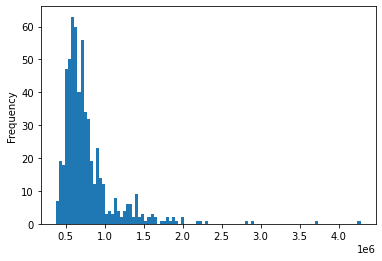

In [56]:
df['Listing_price'].plot(kind = 'hist', bins = 100)

In [57]:
df['Listing_price'].sort_values(ascending = False)[0:20]

83     4280000
80     3700000
153    2900000
541    2799000
51     2295000
127    2249000
159    2199000
52     1999800
82     1990000
78     1919500
389    1875000
388    1875000
162    1850000
164    1800000
21     1800000
20     1760000
156    1739000
19     1665140
160    1649000
144    1600000
Name: Listing_price, dtype: int64

In [58]:
# # Removing the outliers
# my_df = df[df['Listing_price']<2000000]
# print(my_df.shape)
# my_df['Listing_price'].plot(kind = 'hist', bins = 100)

(580, 28)


In [61]:
df['Listing_price'].describe()

count    5.870000e+02
mean     7.817429e+05
std      3.766752e+05
min      3.790000e+05
25%      5.790000e+05
50%      6.799000e+05
75%      8.295000e+05
max      4.280000e+06
Name: Listing_price, dtype: float64

In [ ]:
pd.options.display.float_format = "{:.2f}".format #to print entire numbers

sns.boxplot(my_df['Listing_price'])
print(my_df['Listing_price'].describe())

In [ ]:
# # Determine days on market
import datetime
today = datetime.date.today()
days_on_market = []

for i in range(len(my_df)):
#     print(i)
    try:
        num_days= today-my_df["Listed_on"][i]
        days_on_market.append(num_days)
    except:
        days_on_market.append(np.nan) #parse NaN if blank

In [ ]:
# sum(my_df['Listed_on'].isna())
# sum(my_df['Estimated_on'].isna())
# sum(my_df['Updated_on'].isna())

In [ ]:
# # To make string dates into date objects
# for i in range(len(my_df)):
#     my_df.loc[i,'Listed_on'] = pd.to_datetime(my_df.loc[i, 'Listed_on'], format = '%Y-%m-%d', errors='coerce').date() # NaN -> NaT
#     my_df.loc[i, 'Estimated_on'] = pd.to_datetime(my_df.loc[i, 'Estimated_on'], format = '%Y-%m-%d', errors='coerce').date()
#     my_df.loc[i, 'Updated_on'] = pd.to_datetime(my_df.loc[i, 'Updated_on'], format = '%Y-%m-%d', errors='coerce').date()

In [ ]:
# # # Determine days on market

# today = datetime.date.today()
# days_on_market = []

# for i in range(len(my_df)):
# #     print(i)
#     try:
#         num_days= today-my_df["Listed_on"][i]
#         days_on_market.append(num_days)
#     except:
#         days_on_market.append(np.nan) #parse NaN if blank

In [ ]:
len(days_on_market)

In [ ]:
my_df['Days_on_market'] = pd.Series(days_on_market, index = my_df.index)

In [ ]:
my_df.shape

In [ ]:
# Determine capital gain
my_df['Estimated_capital_gain'] = pd.Series(my_df["Estimated_price"]-my_df["Price"])

In [ ]:
my_df.shape

In [ ]:
pd.set_option('display.max_columns', None)
my_df.head(3)

In [ ]:
num_days = my_df['Days_on_market'].astype('timedelta64[D]')

In [ ]:
sns.scatterplot(x = my_df['Days_on_market'].astype('timedelta64[D]'), y = my_df['Price'])

In [ ]:
sns.scatterplot(x = my_df['Estimated_price'], y = my_df['Price'])

In [ ]:
my_df['Exposure'].value_counts().plot(kind='bar')

In [ ]:
sns.countplot(x = 'Exposure', data = my_df)

In [ ]:
my_df.groupby('Bedroom_num')['Price'].count().sort_values(ascending=False).index

In [ ]:
print(my_df['Bedroom_num'].value_counts().sort_values(ascending=False))
label = my_df['Bedroom_num'].value_counts().sort_values(ascending=False).index
plt.pie(my_df['Bedroom_num'].value_counts().sort_values(ascending=False), labels = label,autopct='%1.1f%%', startangle=350)
plt.axis('equal')
plt.show()

In [ ]:
sns.distplot(my_df['Estimated_price'])
sns.distplot(my_df['Price'])

In [ ]:
sns.distplot(my_df['Estimated_capital_gain'])
print(my_df['Estimated_capital_gain'].describe())

In [ ]:
sns.pairplot(my_df)